# phosphorus - carbon coupled box model

Implementation of coupled model described by van Cappellen and Ingall (1994).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm_notebook

set up reservoir information

In [2]:
n_M = 9
M_desc = ['inorganic carbon',
          'inorganic phosphorus',
          'particulate organic carbon',
          'particulate organic phosphorus',
          'reactive phosphorus',
          'sed organic carbon',
          'sed organic phosphorus',
          'authigenic and biogenic apatite',
          'phosphate sorbed']
M_steady = np.array([65e20, 14e18, 35e14, 18e12, 20e14, 13e20, 52e17, 52e17, 22e17])

M = pd.DataFrame()
M['desc'] = M_desc
M['steady state reservoirs'] = M_steady
M.set_index(np.arange(1, 10), inplace=True)

set up flux quantities and functions

n varies fron 2-3, derived by relating organic carbon burial flux and primary production flux to sedimentation rate and linking tnen via sedimentation rate (eq 3 & 4)

In [77]:
cp_red = 106 #redfield ratio
# cp_bur = 250 # burial ratio

k54 = 3.93e-3 # q/m
k36 = 1.2e-26 # (mol/yr)^1.5
k58 = 5.56e-24 # (mol/yr)^1.5
k59 = 7.6e9 # mol/yr
k_up = 2.88e-9 # 1/yr
k25 = 2.57e-9 # 1/yr
k_oa = 6.58e14 # mol/m

v_mix = 3 # m/yr
n = 2.5
cp_ox = 200
cp_aox = 4000

# carbon: almost all fluxes depend only on M5 (reactive phosphorus reservoir)
def f13(m5):
    return cp_red*f54(m5)

def f31(m5):
    return f13(m5)-f36(m5)

def f36(m5):
    return k36*(f13(m5)**n)

def f61(m6):
    return k_up*m6

# phosphorus
def f54(m5):
    return k54*v_mix*m5

def f45(m5):
    return f54(m5)-f47(m5)

def f47(m5):
    return f36(m5)/cp_bur(m5)

def f58(m5):
    return k58*(f45(m5)**n)

def f59(m5):
    return k59*(1-doa(m5))

# same for 82, 92
def f72(m7):
    return k_up*m7

def f82(m8):
    return k_up*m8

def f92(m9):
    return k_up*m9

def f25(m2):
    return k25*m2

def doa(m5):
    if f13(m5) == 0:
        return 1 
    tmp = 1 - k_oa*(v_mix/f13(m5))
    if tmp < 0:
        tmp = 0
    return tmp

def cp_bur(m5):
    num = cp_ox*cp_aox
    den = (1-doa(m5))*cp_aox + doa(m5)*cp_ox
    return num/den

In [78]:
# reservoir updates
# mi(t+1) = mi(t) + dt*(update)
# the following functions implement (update)
def m1_up(m5, m6):
    return f61(m6) + f31(m5) - f13(m5)

def m2_up(m2, m7, m8, m9):
    return f72(m7) + f82(m8) + f92(m9) - f25(m2)

# assumed to be zero
def m3_up():
#     return f13(m5) - f36(m5) - f31(m5) -> 0
    return 0.

# assumed to be zero
def m4_up():
#     return f54() - f45() - f47() -> 0
    return 0.

def m5_up(m2, m5):
    return f45(m5) + f25(m2) - f54(m5) - f58(m5) - f59(m5)

def m6_up(m5, m6):
    return f36(m5) - f61(m6)

def m7_up(m5, m7):
    return f47(m5) - f72(m7)

def m8_up(m5, m8):
    return f58(m5) - f82(m8)

def m9_up(m5, m9):
    return f59(m5) - f92(m9)

In [79]:
def model(dt, nt):
    M0 = M['steady state reservoirs'].values

    M_out = np.zeros((nt, 9))

    for tt in range(nt):
        # update each reservoir based on values at tt-1
        M_out[tt, 0] = M0[0] + dt*m1_up(M0[4], M0[5])
        M_out[tt, 1] = M0[1] + dt*m2_up(M0[1], M0[6], M0[7], M0[8])
        M_out[tt, 2] = M0[2] + dt*m3_up()
        M_out[tt, 3] = M0[3] + dt*m4_up()
        M_out[tt, 4] = M0[4] + dt*m5_up(M0[1], M0[4])
        M_out[tt, 5] = M0[5] + dt*m6_up(M0[4], M0[5])
        M_out[tt, 6] = M0[6] + dt*m7_up(M0[4], M0[6])
        M_out[tt, 7] = M0[7] + dt*m8_up(M0[4], M0[7])
        M_out[tt, 8] = M0[8] + dt*m9_up(M0[4], M0[8])

        # reset M0
        M0 = M_out[tt,:]
        
    return M_out
    

now do simple first order modeling

## Figure 3

Reproduce figure 3.

In [80]:
dt = 50  # years
nt = 5000 # number of time steps

In [81]:
n_exp = 15
vs_mix = np.linspace(0, 5, n_exp)
M_steady = np.zeros((n_exp, 9))

# compute steady states for varying upwelling velocities
for ii in tqdm_notebook(range(n_exp)):
    v_mix = vs_mix[ii]
    M_out = model(dt, nt)
    M_steady[ii,:] = M_out[-1, :]
    

In [88]:
# compute quantities of interest

doa_tmp = np.zeros(n_exp)
f13_tmp = np.zeros(n_exp)
f36_tmp = np.zeros(n_exp)
f47_tmp = np.zeros(n_exp)
f58_tmp = np.zeros(n_exp)
f59_tmp = np.zeros(n_exp)

for ii in tqdm_notebook(range(n_exp)):
    v_mix = vs_mix[ii]
    doa_tmp[ii] = doa(M_steady[ii, 4])
    f13_tmp[ii] = f13(M_steady[ii, 4])/1e15
    f36_tmp[ii] = f36(M_steady[ii, 4])/1e12
    f47_tmp[ii] = f47(M_steady[ii, 4])/1e9
    f58_tmp[ii] = f58(M_steady[ii, 4])/1e9
    f59_tmp[ii] = f59(M_steady[ii, 4])/1e9

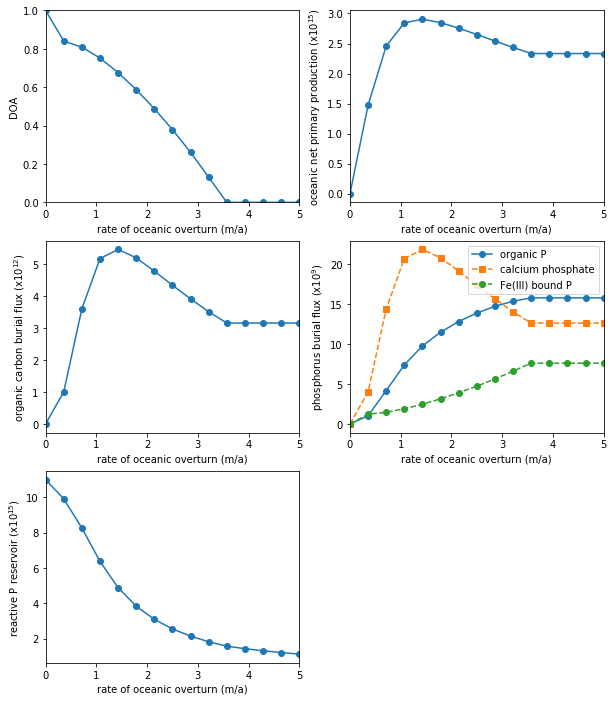

In [93]:
# plot 
    
fig, ax = plt.subplots(3, 2, figsize=(10,12))

ax[0, 0].plot(vs_mix, doa_tmp, '-o')
ax[0, 0].set_xlim([0, 5])
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_xlabel('rate of oceanic overturn (m/a)')
ax[0, 0].set_ylabel('DOA')

ax[0, 1].plot(vs_mix, f13_tmp, '-o')
ax[0, 1].set_xlim([0, 5])
ax[0, 1].set_xlabel('rate of oceanic overturn (m/a)')
ax[0, 1].set_ylabel('oceanic net primary production (x10$^{15}$)')

ax[1, 0].plot(vs_mix, f36_tmp, '-o')
ax[1, 0].set_xlim([0, 5])
ax[1, 0].set_xlabel('rate of oceanic overturn (m/a)')
ax[1, 0].set_ylabel('organic carbon burial flux (x10$^{12}$)')

ax[1, 1].plot(vs_mix, f47_tmp, '-o', label='organic P')
ax[1, 1].plot(vs_mix, f58_tmp, '--s', label='calcium phosphate')
ax[1, 1].plot(vs_mix, f59_tmp, '--o', label='Fe(III) bound P')
ax[1, 1].set_xlim([0, 5])
ax[1, 1].set_xlabel('rate of oceanic overturn (m/a)')
ax[1, 1].set_ylabel('phosphorus burial flux (x10$^{9}$)')
ax[1, 1].legend()

ax[2, 0].plot(vs_mix, M_steady[:,4]/1e15, '-o')
ax[2, 0].set_xlim([0, 5])
ax[2, 0].set_xlabel('rate of oceanic overturn (m/a)')
ax[2, 0].set_ylabel('reactive P reservoir (x10$^{15}$)')

ax[2,1].remove()

plt.show()